## Monitor Data Drift using SHAP/LIME

In [1]:
import numpy as np
import pandas as pd
import joblib
import sys, os
from os.path import join
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.io.io import get_numeric_init_time
from wofs.post.utils import load_yaml
import skexplain 
import shap

from wofs.common.zarr import get_mapper

from display_names import to_display_name, to_units

In [2]:
time = 'first_hour'
target = 'all_sig_severe'

ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_retro.yml')
parameters = {
                'target' : target,
                'time' : time, 
                'drop_opt' : '',
                'model_name' : 'LogisticRegression',
                'ml_config' : ml_config,
            }

model_dict = load_ml_model(**parameters)
model = model_dict['model']
features = model_dict['X'].columns
X_train = model_dict['X']

Loading /work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_all_sig_severe_None_first_hour_realtime.joblib...


In [3]:
def fix_data(X): 
    #X = X.astype({'Initialization Time' : str})
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.reset_index(inplace=True, drop=True)
    
    return X 

In [4]:
# Load data from a recent case. 
base = 'https://cdne-wofs-web.azureedge.net/'
path = join(base,'WOFSRun20230426-142636d1/20230426/2200/wofs_MLDATA_16_20230426_2250_2320.feather')

path = '/home/monte.flora/python_packages/wofs_ml_severe/tests/test_data/wofs_MLDATA_06_20230426_2300_2330.feather'



X = pd.read_feather(path)
#TEMPORARY FIX!!!!
#df['Initialization Time'] = ['2100']*np.shape(df)[0]

#X = df[features]
X = fix_data(X)
#X = get_numeric_init_time(X)

### Check the results of the transformers 

In [5]:
# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
X_train = fix_data(X_train)

# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
shap_kws={'masker' : shap.maskers.Partition(X_train.values.astype(float), 
                                            max_samples=150, clustering="correlation"), 
           'algorithm' : 'permutation'}

In [6]:
display_feature_names = {f: to_display_name(f) for f in X[features].columns}
display_units = {f: to_units(f) for f in X[features].columns}

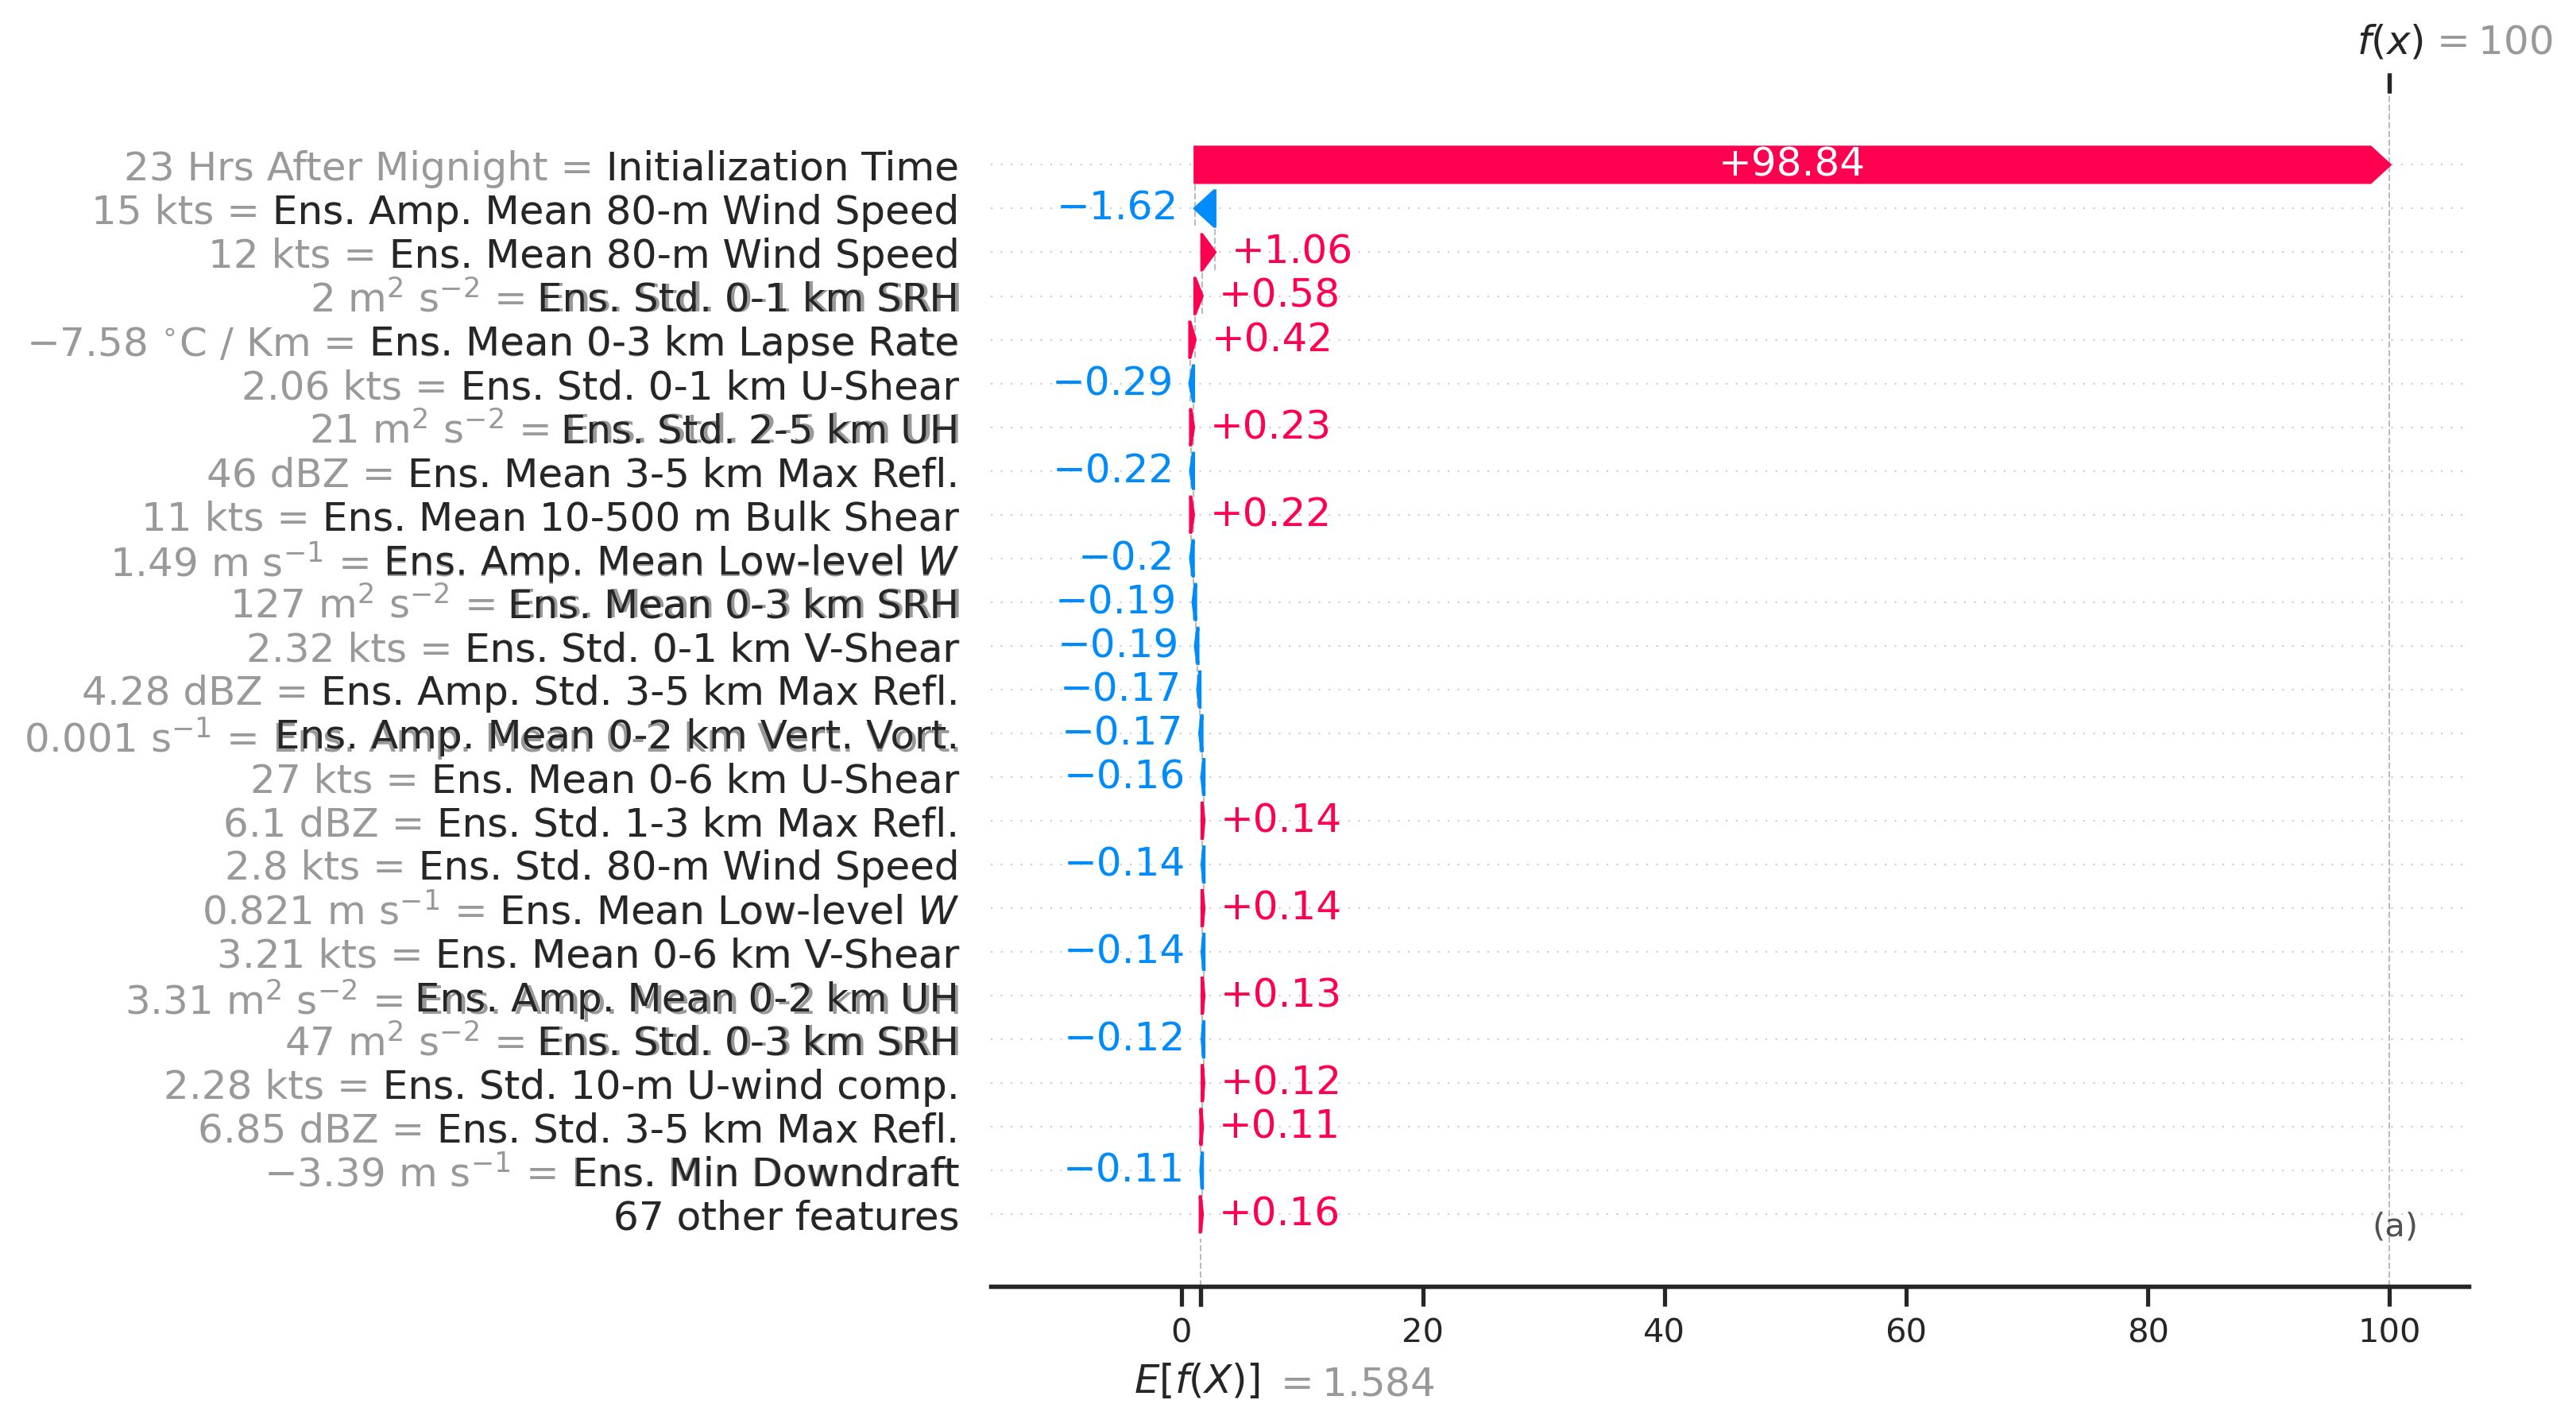

In [9]:
%matplotlib inline

X_test = X[features]

#X_test['Initialization Time'] = 23

pred = model.predict_proba(X_test)[:,1]
inds = np.argsort(pred)[::-1]
ind = inds[0]


single_example = X_test.iloc[[ind]].astype(float)



explainer = skexplain.ExplainToolkit(('LR', model), X=single_example)
contrib_ds = explainer.local_attributions(method='shap', 
                                           shap_kws = shap_kws,
                                          )

fig, axes = explainer.plot_contributions(
    contrib = contrib_ds, 
    display_feature_names = display_feature_names, 
    display_units = display_units, 
    max_display = 25
)

In [10]:
single_example['Initialization Time']

31    2300.0
Name: Initialization Time, dtype: float64